In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

from math import sqrt
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import env
#import os
#import prepare
#my wrangle file 
import wrangle


## I. Acquire Data

In [2]:
# Acquiring the data from the csv file and displaying first 5 rows
df = pd.read_csv('Bank Customer Churn Prediction.csv')

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## II. Clean & Prepare Data

In [4]:
# Checking the number of rows and columns
df.shape

(10000, 12)

In [5]:
#checking the DataFrame for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [6]:
#checking the nulls
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [7]:
#checking overall statistics about the dataset
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
#check DataFrame columns
df.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

In [9]:
#dropping unnecessary columns
df = df.drop(['customer_id'], axis =1)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [10]:
#check country value count
df.country.value_counts()

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

## Heatmap

<AxesSubplot:>

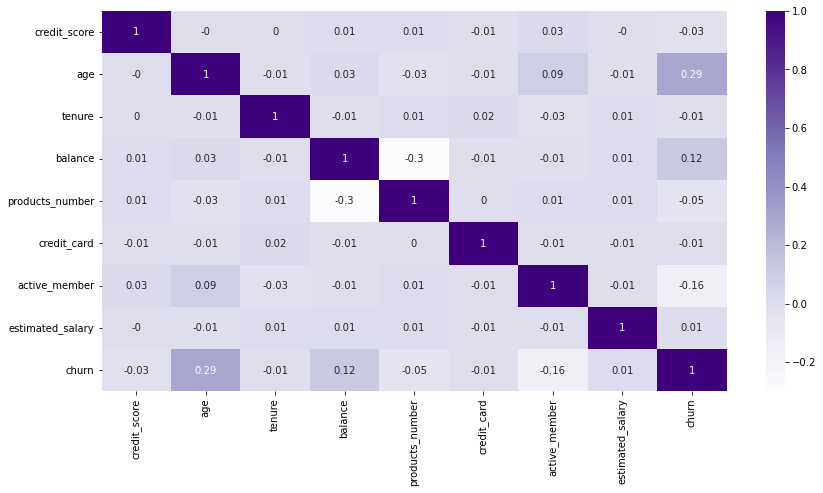

In [11]:
#checking correlation between our variables.
correlation = df.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True,cmap='Purples')

## Takeaway
### Looking at the correlation between variables, we can see that there is no strong correlation between the variables

## III. Exploratory Data Analysis

In [12]:
cat_vars = ['country','gender','active_member', 'credit_card', 'products_number','churn' ]
target = 'churn'
cat_vars2=['country','gender','active_member', 'credit_card', 'products_number']
quant_var = ['credit_score', 'balance', 'estimated_salary', 'age', 'tenure']

## Univariate Analysis
## Categorical Variables

In [13]:
#ploting categorical variables
def plot_cat_vars():
    plt.figure(figsize = (25,25))

    plt.subplot(4,2,1)
    sns.countplot(x = 'country', palette='Set1', data = df)

    plt.subplot(4,2,2)
    sns.countplot(x = 'gender', palette='Set1', data = df)

    plt.subplot(4,2,3)
    sns.countplot(x = 'active_member', palette='Set1', data = df)

    plt.subplot(4,2,4)
    sns.countplot(x = 'credit_card', palette='Set1', data = df)

    plt.subplot(4,2,5)
    sns.countplot(x = 'products_number', palette='Set1', data = df)

    plt.subplot(4,2,6)
    sns.countplot(x = 'churn', palette='Set1', data = df)
    plt.show()
    

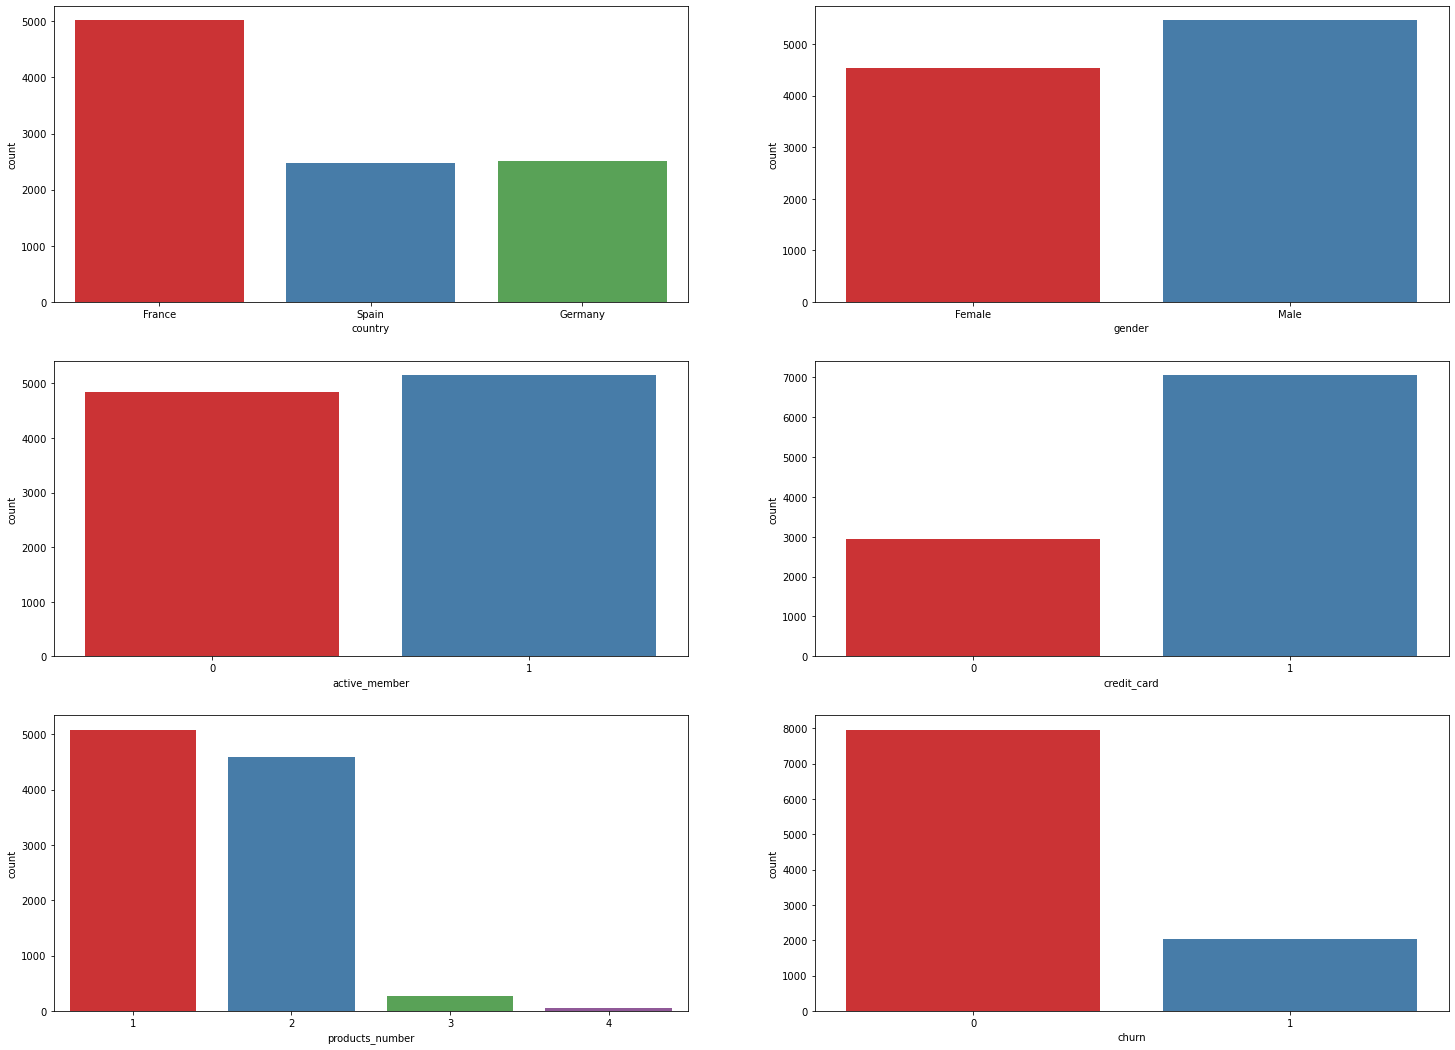

In [14]:
plot_cat_vars()

## Quantitative Variables

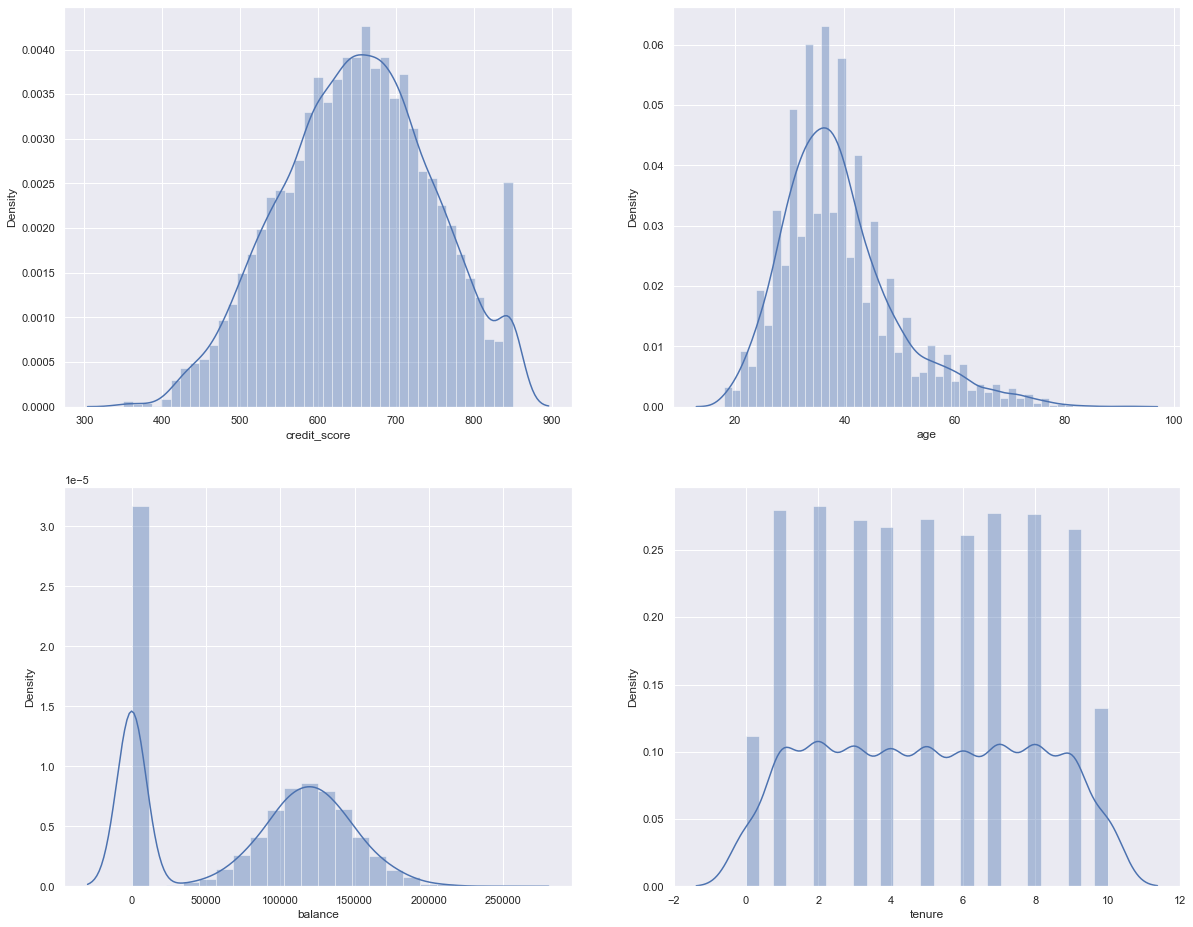

In [15]:
#ploting quantitative variables
plt.figure(figsize = (20,25))

sns.set(color_codes = True)

plt.subplot(3,2,1)
sns.distplot(df['credit_score'])

plt.subplot(3,2,2)
sns.distplot(df['age'])

plt.subplot(3,2,3)
sns.distplot(df['balance'], kde = True)

plt.subplot(3,2,4)
sns.distplot(df['tenure'], kde = True)
plt.show()


## Takeaways:
Looking at our categorical variables:
- We can see that 50% of customers are predominantly from France, and about 25% from Spain and about 25% from Germany
- We can also see a slight amount of male customers greater than female
- We also see slightly more active members than are non active members
- we can also verify that most customers have credit card, therefore most transactions are made by credit card
- looking at the variable product_number, we can see that we have more of products 1 and 2 than the rest.
- when we look at our target variable - churn we can see that we have much more customers leaving.

Looking at our quantitative variables:
- We can see that our credit score variable has a practically normal distribution
- Credit score observation: most frequency is in 600-700 score range
- A look at the age, most people in our base are between ages 20 and 40 years old
- We can also see on the balance that a large number of people who have no value on the balance sheet
- A look at tenure we can see that it has well distributed values

## Data Pre-processing

In [16]:
#encoding categorical column for country
dummies = pd.get_dummies(df.country,drop_first = False)
df=pd.concat([df,dummies],axis=1)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [17]:
#encoding categorical column for gender
dummies = pd.get_dummies(df.gender,drop_first = False)
df=pd.concat([df,dummies],axis=1)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain,Female,Male
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


### Takeaways

- The dataset contains 1000 rows and 12 columns
- The datset has no nulls
- The dataset looks clean with all columns lower case and underscores where necessary
- Dataset had unnecessary column - customer_Id that I dropped not needed for analysis
- I did encode categorical columns country and gender

## Splitting the Data

In [18]:
# this function is splitting data to train, validate, and test to avoid data leakage
def my_train_test_split(df,churn):
    '''
    This function performs split on The bank churn data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df["churn"])
    train, validate = train_test_split(train, test_size=.25, random_state=123, stratify=train["churn"])

    return train, validate, test 

In [19]:
#define data split
train, validate, test = my_train_test_split(df,'churn')

In [20]:
#checking shape of dataset after split
train.shape, validate.shape, test.shape

((6000, 16), (2000, 16), (2000, 16))

In [21]:
#check statistical data distribution
train.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain,Female,Male
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,650.377000,38.882333,5.015833,75571.271055,1.527167,0.705667,0.517000,99893.188622,0.203833,0.504500,0.248333,0.247167,0.449333,0.550667
std,96.156254,10.306512,2.891016,62392.724228,0.575602,0.455780,0.499753,57509.678695,0.402880,0.500021,0.432082,0.431400,0.497468,0.497468
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,91.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50895.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,651.000000,37.000000,5.000000,96647.175000,1.000000,1.000000,1.000000,99812.150000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,717.250000,44.000000,8.000000,126995.585000,2.000000,1.000000,1.000000,149079.755000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
train.head(3)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain,Female,Male
4053,550,Spain,Male,51,5,0.0,2,1,0,153917.41,0,0,0,1,0,1
9797,627,Spain,Male,40,10,0.0,2,1,1,194792.42,0,0,0,1,0,1
4101,673,Spain,Female,57,4,0.0,2,1,1,49684.09,0,0,0,1,1,0


## Bivariate Analysis

In [23]:
cat_vars = ['country','gender','active_member', 'credit_card', 'products_number','churn' ]
target = 'churn'
cat_vars2=['country','gender','active_member', 'credit_card', 'products_number']
quant_var = ['credit_score', 'balance', 'estimated_salary', 'age', 'tenure']

In [24]:
def run_chi2(train, cat_var, churn):
    observed = pd.crosstab(train[cat_var], train[churn])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    chi2_summary = pd.DataFrame({'chi2': [chi2], 'p-value': [p], 
                                 'degrees of freedom': [degf]})
    expected = pd.DataFrame(expected)
    return chi2_summary, observed, expected

In [25]:
#run_chi2(train, cat_vars, 'churn')

## Scaling

In [26]:
# we will drop our target variable, country & gender before scaling
X = df.drop(['churn', 'country', 'gender'], axis='columns')
Y = df['churn']

 
# splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 42)

In [27]:
X_train.head(2)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,France,Germany,Spain,Female,Male
9069,619,32,4,175406.13,2,1,1,172792.43,0,0,1,1,0
2603,643,34,7,160426.07,1,0,1,188533.11,0,1,0,1,0


In [28]:
# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

In [29]:
X_train.shape, X_test.shape

((7000, 13), (3000, 13))

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   age               10000 non-null  int64  
 2   tenure            10000 non-null  int64  
 3   balance           10000 non-null  float64
 4   products_number   10000 non-null  int64  
 5   credit_card       10000 non-null  int64  
 6   active_member     10000 non-null  int64  
 7   estimated_salary  10000 non-null  float64
 8   France            10000 non-null  uint8  
 9   Germany           10000 non-null  uint8  
 10  Spain             10000 non-null  uint8  
 11  Female            10000 non-null  uint8  
 12  Male              10000 non-null  uint8  
dtypes: float64(2), int64(6), uint8(5)
memory usage: 674.0 KB


# IV. Modeling

## Random Forest

In [38]:
# make the thing 
rf = RandomForestClassifier(min_samples_leaf = 1, max_depth = 100)

In [39]:
# fit the thing
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=100)

In [40]:
# use the thing
y_pred = rf.predict(X_train)

In [41]:
y_pred

array([1, 0, 0, ..., 1, 1, 0])